# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [1]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE
# Install the required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import scipy
import os, shutil
import time
import cv2

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# helper functions
def rotate_image(img_path):
    image = cv2.imread(img_path)
    height, width = image.shape[:2]
    # Divide by two to rotate the image around its centre
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 180, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    save_rot = cv2.imwrite(img_path, rotated_image)
    return

In [4]:
# # Create directories to store images

# # Original directory where the dataset is stored (25,000 images of cats and dogs)
# original_dataset_dir = 'content/drive/datasets'

# # Base directory to store the dataset required for this task
# # We shall copy a subset of the original dataset to the base dir
# base_dir = '/content/drive/dataset'
# if not os.path.exists(base_dir):
#     os.mkdir(base_dir)

#     train_dir = os.path.join(base_dir, 'train')
#     os.mkdir(train_dir)

#     validation_dir = os.path.join(base_dir, 'validation')
#     os.mkdir(validation_dir)

#     test_dir = os.path.join(base_dir, 'test')
#     os.mkdir(test_dir)

#     train_unrotated_dir = os.path.join(train_dir, 'unrotated')
#     os.mkdir(train_unrotated_dir)
#     train_rotated_dir = os.path.join(train_dir, 'rotated')
#     os.mkdir(train_rotated_dir)

#     val_unrotated_dir = os.path.join(validation_dir, 'unrotated')
#     os.mkdir(val_unrotated_dir)
#     val_rotated_dir = os.path.join(validation_dir, 'rotated')
#     os.mkdir(val_rotated_dir)

#     test_unrotated_dir = os.path.join(test_dir, 'unrotated')
#     os.mkdir(test_unrotated_dir)
#     test_rotated_dir = os.path.join(test_dir, 'rotated')
#     os.mkdir(test_rotated_dir)

# else:
#     pass



In [5]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
tf.config.run_functions_eagerly(False)
print("Eager execution: {}".format(tf.executing_eagerly()))
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard


TensorFlow version: 2.8.0
Eager execution: True


In [6]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
#     value = tensor[0][0][0]
#     wtm = tf.fill((10,10,1), value)
    

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding ='same', kernel_initializer= initializer(seed = 0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, padding='valid', strides = (1,1),  kernel_initializer= initializer(seed = 0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X


def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides=(1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides=(1,1), padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides=(s,s), padding='valid', kernel_initializer= initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training = training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def ResNet50(input_shape = (224, 224, 3), classes = 2):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [128, 128, 512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [256, 256, 1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024]) 

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X) 
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [7]:
model = ResNet50(input_shape = (224, 224, 3), classes = 1)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [8]:
# Compile model
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-2), metrics=['acc'])

In [9]:
#Datasets directory
train_dir = '/content/drive/MyDrive/dataset/train'
validation_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

In [10]:
# Preprocesing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_datagen = train_gen.flow_from_directory(train_dir, class_mode='binary', batch_size=20,target_size=(224, 224))
val_datagen = test_gen.flow_from_directory(validation_dir, class_mode='binary', batch_size=20, target_size=(224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
model_name = 'UpsideDownDetector'
output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
monitor = 'val_acc'
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    monitor=monitor,
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=3)
early_stopping = EarlyStopping(monitor=monitor, patience=5)
tensorboard = TensorBoard()

# Train the model
history = model.fit_generator(train_datagen, steps_per_epoch=100, epochs = 50, validation_data=val_datagen, validation_steps=50,
    callbacks=[checkpointer, reduce_lr, early_stopping, tensorboard],
    workers=10)

model.save(model_name+'.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
100/100 [==============================] - 137s 998ms/step - loss: 5.3076 - acc: 0.5070 - val_loss: 1.0500 - val_acc: 0.5150 - lr: 0.0100
Epoch 2/50
100/100 [==============================] - 67s 662ms/step - loss: 1.3559 - acc: 0.5170 - val_loss: 3.3890 - val_acc: 0.5210 - lr: 0.0100
Epoch 3/50
100/100 [==============================] - 66s 649ms/step - loss: 1.1363 - acc: 0.5165 - val_loss: 0.6971 - val_acc: 0.4950 - lr: 0.0100
Epoch 4/50
100/100 [==============================] - 66s 649ms/step - loss: 0.7540 - acc: 0.4920 - val_loss: 0.6938 - val_acc: 0.5130 - lr: 0.0100
Epoch 5/50
100/100 [==============================] - 66s 647ms/step - loss: 0.8100 - acc: 0.5155 - val_loss: 0.7444 - val_acc: 0.5140 - lr: 0.0100
Epoch 6/50
100/100 [==============================] - 67s 662ms/step - loss: 0.7020 - acc: 0.5435 - val_loss: 0.6793 - val_acc: 0.5820 - lr: 1.0000e-03
Epoch 7/50
100/100 [==============================] - 68s 675ms/step - loss: 0.6769 - acc: 0.5710 - val_los

In [12]:
#Evaluate model on test set
test_datagen = test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_datagen, steps=50)
print('test accuracy: ', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


test accuracy:  0.9430000185966492


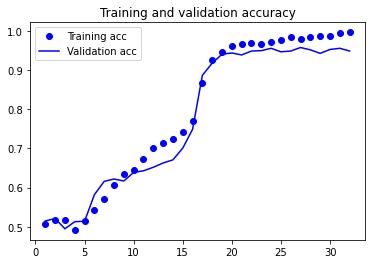

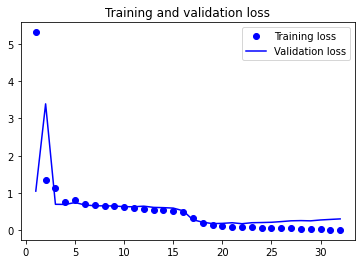

In [13]:
# Plot training and validtion accuracy/loss curve
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
# Test the model
test_rot = '/content/drive/MyDrive/dataset/test/rotated/'
test_unrot = '/content/drive/MyDrive/dataset/test/unrotated/'

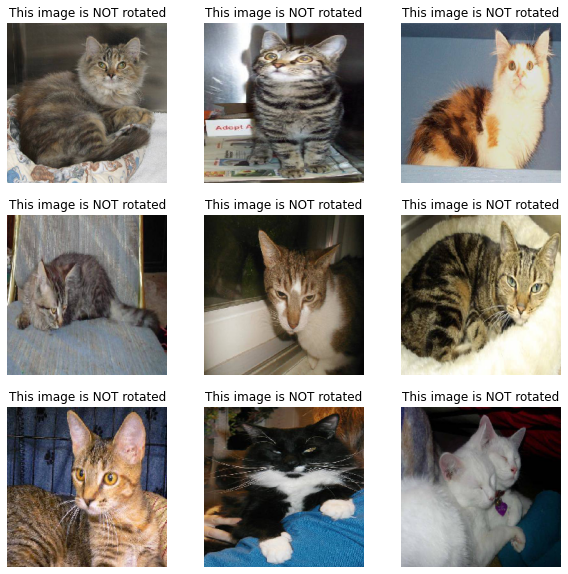

In [60]:
# Predict the result
from tensorflow.keras.preprocessing import image
result = np.zeros((10))

fig = plt.figure(figsize=(10, 10))
# result = model.predict(test_image)
for i in range(0, 9):
  test_image = image.load_img(test_unrot+os.listdir(test_unrot)[i], target_size = ((224, 224)))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image /= 255
  val = model.predict(test_image)
  ax = plt.subplot(3, 3,i+1 )
  plt.imshow(test_image[0])
  plt.axis('off')
  if val > 0.5:
    plt.title('This image is NOT rotated')
    result[i] = 1
  elif val < 0.5:
    plt.title("This image is rotated")
    result[i] = 0
plt.show()

  

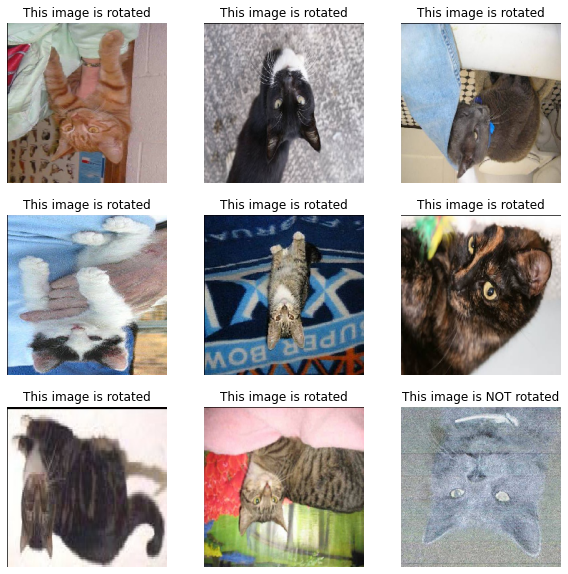

In [73]:
# Predict the result
from tensorflow.keras.preprocessing import image
result = np.zeros((10))

fig = plt.figure(figsize=(10, 10))
# result = model.predict(test_image)
for i in range(0, 9):
  test_image = image.load_img(test_rot+os.listdir(test_rot)[i], target_size = ((224, 224)))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image /= 255
  val = model.predict(test_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(test_image[0])
  plt.axis('off')
  if val > 0.5:
    plt.title('This image is NOT rotated')
    result[i] = 1
  elif val < 0.5:
    plt.title("This image is rotated")
    result[i] = 0
plt.show()

  

In [27]:
!zip -r /content/logs.zip /content/logs
!zip -r /content/models.zip /content/models

  adding: content/logs/ (stored 0%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1649614492.9fe17b7d83bb.71.1.v2 (deflated 76%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1649614393.9fe17b7d83bb.71.0.v2 (deflated 94%)
  adding: content/models/ (stored 0%)
  adding: content/models/UpsideDownDetector.hdf5 (deflated 8%)


**WRITE UP**

Link to the model on Hugging Face Hub: https://huggingface.co/Ayobami/UpsideDownDetector/tree/main

Link to the trained weights: https://drive.google.com/file/d/1F4Lr5aQMMNhDAvul2vsgHt1SarTM_YhY/view?usp=sharing

Examples of images that were misclassified are given plotted in the cell below:



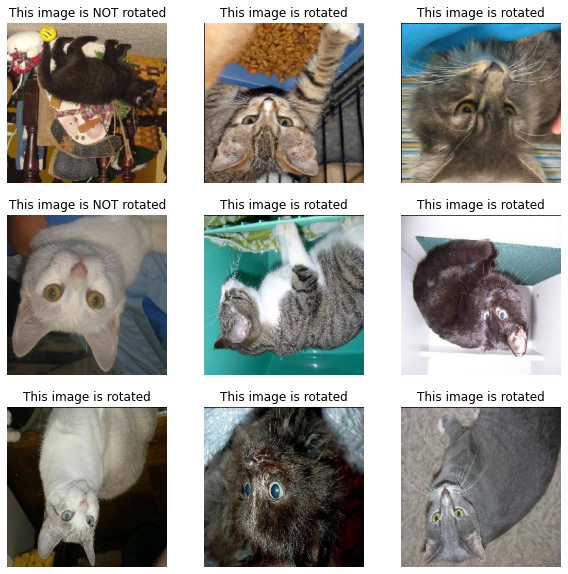

In [74]:
# Some misclassified images
from tensorflow.keras.preprocessing import image

fig = plt.figure(figsize=(10, 10))
for i in range(0, 9):
  test_image = image.load_img(test_rot+os.listdir(test_rot)[i+20], target_size = ((224, 224)))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image /= 255
  val = model.predict(test_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(test_image[0])
  plt.axis('off')
  if val > 0.5:
    plt.title('This image is NOT rotated')
  elif val < 0.5:
    plt.title("This image is rotated")
plt.show()

  

This model was trained on the ResNet50 architecture from scratch. One way to improve this model's performance is to use data augumentation. Another way to increase this model's performance is to use a pretrained model (say ResNet50) and do some fine tuning on the weights.

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?